# M2608.001300 Machine Learning<br> Assignment #3 Training Convolutional Neural Networks (Pytorch)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Yeongtak Oh, May 2024

**For understanding of this work, please carefully look at given PPT file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **2 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.


### Some helpful tutorials and references for assignment #3:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

In [1]:
#Colab setting cell
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/ML/Assignment3')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/ML/Assignment3')

Mounted at /content/drive


## 1. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(36, 138, 3)


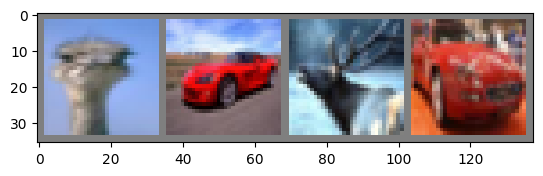

 bird   car  deer   car
torch.Size([3, 32, 32])


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

## 2. Training a small CNN model

#### CNN architecture in order:
* 7x7 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 100 output units and ReLU activation
* Fully connected layer with 80 output units and ReLU activation
* Fully connected layer with 10 output units and linear activation
* You can use any padding option.

#### Training setup:
* Loss function: Softmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 4 (Things you can try to change)
* Training epoch: 2

In [ ]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 100)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 10)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the feature maps
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x

net = Net()

In [ ]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [ ]:
# Define a Loss function and optimizer
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

In [ ]:
# Function to train the network

def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [ ]:
PATH = './cifar_net.pth'
epoch = 2
train(net, trainloader, epoch, criterion, optimizer, PATH)

[1,  2000] loss: 2.303
[1,  4000] loss: 2.301
[1,  6000] loss: 2.298
[1,  8000] loss: 2.291
[1, 10000] loss: 2.276
[1, 12000] loss: 2.216
[2,  2000] loss: 2.040
[2,  4000] loss: 1.954
[2,  6000] loss: 1.916
[2,  8000] loss: 1.872
[2, 10000] loss: 1.830
[2, 12000] loss: 1.769
Finished Training
Saved Trained Model


In [4]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [ ]:
# load trained model then test
net.load_state_dict(torch.load(PATH))
print_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 36 %


## 3. Design a better model on CIFAR-10
Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the test set</font>** of CIFAR-10. <br> You can use the implemented *inception class* below.

### Things you can try to change:
- Batch size (input parameter of dataloader)
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles

In [11]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
# Function to train the network
log_interval = 100

def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % log_interval == log_interval - 1:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / log_interval))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [13]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [14]:
# Define a CNN model
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        self.conv1 =  nn.Sequential(
            nn.Conv2d(3, 192,kernel_size = 3, stride = 1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True)
        )
        #self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        """
        self.conv2 =  nn.Sequential(
            nn.Conv2d(64, 192,kernel_size = 3, stride = 1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True)
        )
        """

        # in_channels , out_1x1 , red_3x3 , out_3x3 , red_5x5 , out_5x5 , out_1x1_pooling
        self.inception3a = Inception(192,64,96,128,16,32,32)
        self.inception3b = Inception(256,128,128,192,32,96,64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.inception4a = Inception(480,192,96,208,16,48,64)
        self.inception4b = Inception(512,160,112,224,24,64,64)

        # Added max pool
        self.maxpool4_1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.inception4c = Inception(512,128,128,256,24,64,64)

        # Added max pool
        self.maxpool4_2 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.inception4d = Inception(512,112,144,288,32,64,64)
        self.inception4e = Inception(528,256,160,320,32,128,128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.inception5a = Inception(832,256,160,320,32,128,128)
        self.inception5b = Inception(832,384,192,384,48,128,128)

        self.avgpool = nn.AvgPool2d(kernel_size = 2 , stride = 1)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear( 1024 , 10)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        x = self.conv1(x)
        #print('conv1',x.shape)
        #x = self.maxpool1(x)
        #print('maxpool1',x.shape)

        #x = self.conv2(x)
        #print('conv2',x.shape)
        #x = self.maxpool2(x)
        #print('maxpool2',x.shape)

        x = self.inception3a(x)
        #print('3a',x.shape)

        x = self.inception3b(x)
        #print('3b',x.shape)

        x = self.maxpool3(x)
        #print('3bmax',x.shape)

        x = self.inception4a(x)
        #print('4a',x.shape)

        x = self.inception4b(x)
        #print('4b',x.shape)

        x = self.maxpool4_1(x)

        x = self.inception4c(x)
        #print('4c',x.shape)

        x = self.maxpool4_2(x)

        x = self.inception4d(x)
        #print('4d',x.shape)

        x = self.inception4e(x)
        #print('4e',x.shape)

        x = self.maxpool4(x)
        #print('maxpool',x.shape)


        #x = self.inception5a(x)
        #print('5a',x.shape)

        x = self.inception5b(x)
        #print('5b',x.shape)

        x = self.avgpool(x)
        #print('AvgPool',x.shape)

        #x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        out = self.fc1(x)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return out

betternet = BetterNet()
betternet = betternet.to(device)

In [15]:
# Define a Loss function and optimizer
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(betternet.parameters(), lr=1e-3)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

In [16]:
PATH = './better_net.pth'
# Train
train(betternet, trainloader, 2, criterion, optimizer, PATH)
# Test
betternet.load_state_dict(torch.load(PATH))
print_accuracy(betternet, testloader)

[1,   100] loss: 1.506
[1,   200] loss: 1.045
[1,   300] loss: 0.877
[2,   100] loss: 0.612
[2,   200] loss: 0.585
[2,   300] loss: 0.552
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 82 %


### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

_Tell us here_

## Results


In [ ]:
from torchsummary import summary

In [ ]:
summary(betternet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 32, 32]           5,376
       BatchNorm2d-2          [-1, 192, 32, 32]             384
              ReLU-3          [-1, 192, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          12,352
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 96, 32, 32]          18,528
       BatchNorm2d-8           [-1, 96, 32, 32]             192
              ReLU-9           [-1, 96, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         110,720
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           3,088
      BatchNorm2d-14           [-1, 16,

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1          [-1, 192, 32, 32]           5,376
       BatchNorm2d-2          [-1, 192, 32, 32]             384
              ReLU-3          [-1, 192, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          12,352
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 96, 32, 32]          18,528
       BatchNorm2d-8           [-1, 96, 32, 32]             192
              ReLU-9           [-1, 96, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]         110,720
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           3,088
      BatchNorm2d-14           [-1, 16, 32, 32]              32
             ReLU-15           [-1, 16, 32, 32]               0
           Conv2d-16           [-1, 32, 32, 32]           4,640
      BatchNorm2d-17           [-1, 32, 32, 32]              64
             ReLU-18           [-1, 32, 32, 32]               0
           Conv2d-19           [-1, 32, 32, 32]           9,248
      BatchNorm2d-20           [-1, 32, 32, 32]              64
             ReLU-21           [-1, 32, 32, 32]               0
        MaxPool2d-22          [-1, 192, 32, 32]               0
           Conv2d-23           [-1, 32, 32, 32]           6,176
      BatchNorm2d-24           [-1, 32, 32, 32]              64
             ReLU-25           [-1, 32, 32, 32]               0
        Inception-26          [-1, 256, 32, 32]               0
           Conv2d-27          [-1, 128, 32, 32]          32,896
      BatchNorm2d-28          [-1, 128, 32, 32]             256
             ReLU-29          [-1, 128, 32, 32]               0
           Conv2d-30          [-1, 128, 32, 32]          32,896
      BatchNorm2d-31          [-1, 128, 32, 32]             256
             ReLU-32          [-1, 128, 32, 32]               0
           Conv2d-33          [-1, 192, 32, 32]         221,376
      BatchNorm2d-34          [-1, 192, 32, 32]             384
             ReLU-35          [-1, 192, 32, 32]               0
           Conv2d-36           [-1, 32, 32, 32]           8,224
      BatchNorm2d-37           [-1, 32, 32, 32]              64
             ReLU-38           [-1, 32, 32, 32]               0
           Conv2d-39           [-1, 96, 32, 32]          27,744
      BatchNorm2d-40           [-1, 96, 32, 32]             192
             ReLU-41           [-1, 96, 32, 32]               0
           Conv2d-42           [-1, 96, 32, 32]          83,040
      BatchNorm2d-43           [-1, 96, 32, 32]             192
             ReLU-44           [-1, 96, 32, 32]               0
        MaxPool2d-45          [-1, 256, 32, 32]               0
           Conv2d-46           [-1, 64, 32, 32]          16,448
      BatchNorm2d-47           [-1, 64, 32, 32]             128
             ReLU-48           [-1, 64, 32, 32]               0
        Inception-49          [-1, 480, 32, 32]               0
        MaxPool2d-50          [-1, 480, 16, 16]               0
           Conv2d-51          [-1, 192, 16, 16]          92,352
      BatchNorm2d-52          [-1, 192, 16, 16]             384
             ReLU-53          [-1, 192, 16, 16]               0
           Conv2d-54           [-1, 96, 16, 16]          46,176
      BatchNorm2d-55           [-1, 96, 16, 16]             192
             ReLU-56           [-1, 96, 16, 16]               0
           Conv2d-57          [-1, 208, 16, 16]         179,920
      BatchNorm2d-58          [-1, 208, 16, 16]             416
             ReLU-59          [-1, 208, 16, 16]               0
           Conv2d-60           [-1, 16, 16, 16]           7,696
      BatchNorm2d-61           [-1, 16, 16, 16]              32
             ReLU-62           [-1, 16, 16, 16]               0
           Conv2d-63           [-1, 48, 16, 16]           6,960
      BatchNorm2d-64           [-1, 48, 16, 16]              96
             ReLU-65           [-1, 48, 16, 16]               0
           Conv2d-66           [-1, 48, 16, 16]          20,784
      BatchNorm2d-67           [-1, 48, 16, 16]              96
             ReLU-68           [-1, 48, 16, 16]               0
        MaxPool2d-69          [-1, 480, 16, 16]               0
           Conv2d-70           [-1, 64, 16, 16]          30,784
      BatchNorm2d-71           [-1, 64, 16, 16]             128
             ReLU-72           [-1, 64, 16, 16]               0
        Inception-73          [-1, 512, 16, 16]               0
           Conv2d-74          [-1, 160, 16, 16]          82,080
      BatchNorm2d-75          [-1, 160, 16, 16]             320
             ReLU-76          [-1, 160, 16, 16]               0
           Conv2d-77          [-1, 112, 16, 16]          57,456
      BatchNorm2d-78          [-1, 112, 16, 16]             224
             ReLU-79          [-1, 112, 16, 16]               0
           Conv2d-80          [-1, 224, 16, 16]         226,016
      BatchNorm2d-81          [-1, 224, 16, 16]             448
             ReLU-82          [-1, 224, 16, 16]               0
           Conv2d-83           [-1, 24, 16, 16]          12,312
      BatchNorm2d-84           [-1, 24, 16, 16]              48
             ReLU-85           [-1, 24, 16, 16]               0
           Conv2d-86           [-1, 64, 16, 16]          13,888
      BatchNorm2d-87           [-1, 64, 16, 16]             128
             ReLU-88           [-1, 64, 16, 16]               0
           Conv2d-89           [-1, 64, 16, 16]          36,928
      BatchNorm2d-90           [-1, 64, 16, 16]             128
             ReLU-91           [-1, 64, 16, 16]               0
        MaxPool2d-92          [-1, 512, 16, 16]               0
           Conv2d-93           [-1, 64, 16, 16]          32,832
      BatchNorm2d-94           [-1, 64, 16, 16]             128
             ReLU-95           [-1, 64, 16, 16]               0
        Inception-96          [-1, 512, 16, 16]               0
           Conv2d-97          [-1, 128, 16, 16]          65,664
      BatchNorm2d-98          [-1, 128, 16, 16]             256
             ReLU-99          [-1, 128, 16, 16]               0
          Conv2d-100          [-1, 128, 16, 16]          65,664
     BatchNorm2d-101          [-1, 128, 16, 16]             256
            ReLU-102          [-1, 128, 16, 16]               0
          Conv2d-103          [-1, 256, 16, 16]         295,168
     BatchNorm2d-104          [-1, 256, 16, 16]             512
            ReLU-105          [-1, 256, 16, 16]               0
          Conv2d-106           [-1, 24, 16, 16]          12,312
     BatchNorm2d-107           [-1, 24, 16, 16]              48
            ReLU-108           [-1, 24, 16, 16]               0
          Conv2d-109           [-1, 64, 16, 16]          13,888
     BatchNorm2d-110           [-1, 64, 16, 16]             128
            ReLU-111           [-1, 64, 16, 16]               0
          Conv2d-112           [-1, 64, 16, 16]          36,928
     BatchNorm2d-113           [-1, 64, 16, 16]             128
            ReLU-114           [-1, 64, 16, 16]               0
       MaxPool2d-115          [-1, 512, 16, 16]               0
          Conv2d-116           [-1, 64, 16, 16]          32,832
     BatchNorm2d-117           [-1, 64, 16, 16]             128
            ReLU-118           [-1, 64, 16, 16]               0
       Inception-119          [-1, 512, 16, 16]               0
          Conv2d-120          [-1, 112, 16, 16]          57,456
     BatchNorm2d-121          [-1, 112, 16, 16]             224
            ReLU-122          [-1, 112, 16, 16]               0
          Conv2d-123          [-1, 144, 16, 16]          73,872
     BatchNorm2d-124          [-1, 144, 16, 16]             288
            ReLU-125          [-1, 144, 16, 16]               0
          Conv2d-126          [-1, 288, 16, 16]         373,536
     BatchNorm2d-127          [-1, 288, 16, 16]             576
            ReLU-128          [-1, 288, 16, 16]               0
          Conv2d-129           [-1, 32, 16, 16]          16,416
     BatchNorm2d-130           [-1, 32, 16, 16]              64
            ReLU-131           [-1, 32, 16, 16]               0
          Conv2d-132           [-1, 64, 16, 16]          18,496
     BatchNorm2d-133           [-1, 64, 16, 16]             128
            ReLU-134           [-1, 64, 16, 16]               0
          Conv2d-135           [-1, 64, 16, 16]          36,928
     BatchNorm2d-136           [-1, 64, 16, 16]             128
            ReLU-137           [-1, 64, 16, 16]               0
       MaxPool2d-138          [-1, 512, 16, 16]               0
          Conv2d-139           [-1, 64, 16, 16]          32,832
     BatchNorm2d-140           [-1, 64, 16, 16]             128
            ReLU-141           [-1, 64, 16, 16]               0
       Inception-142          [-1, 528, 16, 16]               0
          Conv2d-143          [-1, 256, 16, 16]         135,424
     BatchNorm2d-144          [-1, 256, 16, 16]             512
            ReLU-145          [-1, 256, 16, 16]               0
          Conv2d-146          [-1, 160, 16, 16]          84,640
     BatchNorm2d-147          [-1, 160, 16, 16]             320
            ReLU-148          [-1, 160, 16, 16]               0
          Conv2d-149          [-1, 320, 16, 16]         461,120
     BatchNorm2d-150          [-1, 320, 16, 16]             640
            ReLU-151          [-1, 320, 16, 16]               0
          Conv2d-152           [-1, 32, 16, 16]          16,928
     BatchNorm2d-153           [-1, 32, 16, 16]              64
            ReLU-154           [-1, 32, 16, 16]               0
          Conv2d-155          [-1, 128, 16, 16]          36,992
     BatchNorm2d-156          [-1, 128, 16, 16]             256
            ReLU-157          [-1, 128, 16, 16]               0
          Conv2d-158          [-1, 128, 16, 16]         147,584
     BatchNorm2d-159          [-1, 128, 16, 16]             256
            ReLU-160          [-1, 128, 16, 16]               0
       MaxPool2d-161          [-1, 528, 16, 16]               0
          Conv2d-162          [-1, 128, 16, 16]          67,712
     BatchNorm2d-163          [-1, 128, 16, 16]             256
            ReLU-164          [-1, 128, 16, 16]               0
       Inception-165          [-1, 832, 16, 16]               0
       MaxPool2d-166            [-1, 832, 8, 8]               0
          Conv2d-167            [-1, 256, 8, 8]         213,248
     BatchNorm2d-168            [-1, 256, 8, 8]             512
            ReLU-169            [-1, 256, 8, 8]               0
          Conv2d-170            [-1, 160, 8, 8]         133,280
     BatchNorm2d-171            [-1, 160, 8, 8]             320
            ReLU-172            [-1, 160, 8, 8]               0
          Conv2d-173            [-1, 320, 8, 8]         461,120
     BatchNorm2d-174            [-1, 320, 8, 8]             640
            ReLU-175            [-1, 320, 8, 8]               0
          Conv2d-176             [-1, 32, 8, 8]          26,656
     BatchNorm2d-177             [-1, 32, 8, 8]              64
            ReLU-178             [-1, 32, 8, 8]               0
          Conv2d-179            [-1, 128, 8, 8]          36,992
     BatchNorm2d-180            [-1, 128, 8, 8]             256
            ReLU-181            [-1, 128, 8, 8]               0
          Conv2d-182            [-1, 128, 8, 8]         147,584
     BatchNorm2d-183            [-1, 128, 8, 8]             256
            ReLU-184            [-1, 128, 8, 8]               0
       MaxPool2d-185            [-1, 832, 8, 8]               0
          Conv2d-186            [-1, 128, 8, 8]         106,624
     BatchNorm2d-187            [-1, 128, 8, 8]             256
            ReLU-188            [-1, 128, 8, 8]               0
       Inception-189            [-1, 832, 8, 8]               0
          Conv2d-190            [-1, 384, 8, 8]         319,872
     BatchNorm2d-191            [-1, 384, 8, 8]             768
            ReLU-192            [-1, 384, 8, 8]               0
          Conv2d-193            [-1, 192, 8, 8]         159,936
     BatchNorm2d-194            [-1, 192, 8, 8]             384
            ReLU-195            [-1, 192, 8, 8]               0
          Conv2d-196            [-1, 384, 8, 8]         663,936
     BatchNorm2d-197            [-1, 384, 8, 8]             768
            ReLU-198            [-1, 384, 8, 8]               0
          Conv2d-199             [-1, 48, 8, 8]          39,984
     BatchNorm2d-200             [-1, 48, 8, 8]              96
            ReLU-201             [-1, 48, 8, 8]               0
          Conv2d-202            [-1, 128, 8, 8]          55,424
     BatchNorm2d-203            [-1, 128, 8, 8]             256
            ReLU-204            [-1, 128, 8, 8]               0
          Conv2d-205            [-1, 128, 8, 8]         147,584
     BatchNorm2d-206            [-1, 128, 8, 8]             256
            ReLU-207            [-1, 128, 8, 8]               0
       MaxPool2d-208            [-1, 832, 8, 8]               0
          Conv2d-209            [-1, 128, 8, 8]         106,624
     BatchNorm2d-210            [-1, 128, 8, 8]             256
            ReLU-211            [-1, 128, 8, 8]               0
       Inception-212           [-1, 1024, 8, 8]               0
       AvgPool2d-213           [-1, 1024, 1, 1]               0
          Linear-214                   [-1, 10]          10,250
================================================================
Total params: 6,166,250
Trainable params: 6,166,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 81.42
Params size (MB): 23.52
Estimated Total Size (MB): 104.96
----------------------------------------------------------------
```

### lr = 0.001, batch = 64, dropout = 0
```
[1,   200] loss: 1.613
[1,   400] loss: 1.261
[1,   600] loss: 1.075
[2,   200] loss: 0.849
[2,   400] loss: 0.796
[2,   600] loss: 0.751
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 75 %
```

### lr = 0.001, batch = 128, dropout = 0
```
[1,   100] loss: 1.627
[1,   200] loss: 1.238
[1,   300] loss: 1.070
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2,   100] loss: 0.836
[2,   200] loss: 0.787
[2,   300] loss: 0.705
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 76 %
```

### lr = 0.002, batch = 128, dropout = 0
```
[1,   100] loss: 1.771
[1,   200] loss: 1.430
[1,   300] loss: 1.229
[2,   100] loss: 0.989
[2,   200] loss: 0.872
[2,   300] loss: 0.835
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 74 %
```

### lr = 0.004, batch = 128, dropout = 0
```
[1,   100] loss: 1.886
[1,   200] loss: 1.559
[1,   300] loss: 1.352
[2,   100] loss: 1.129
[2,   200] loss: 1.032
[2,   300] loss: 0.953
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 68 %
```

### lr = 0.0005, batch = 128, dropout = 0
```
[1,   100] loss: 1.520
[1,   200] loss: 1.102
[1,   300] loss: 0.951
[2,   100] loss: 0.706
[2,   200] loss: 0.672
[2,   300] loss: 0.610
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 79 %
```

### lr = 0.0001, batch = 128, dropout = 0
```
[1,   100] loss: 1.561
[1,   200] loss: 1.199
```

### lr = 5e-4, batch = 256, dropout = 0
```
[1,   100] loss: 1.363
[2,   100] loss: 0.688
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 79 %
```
### Added self.maxpool1
```
[1,   100] loss: 1.381
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2,   100] loss: 0.774
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 76 %
```

```python
self.conv1 =  nn.Sequential(
            nn.Conv2d(3, 64,kernel_size = 1, stride = 1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        #self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
self.conv2 =  nn.Sequential(
            nn.Conv2d(64, 192,kernel_size = 3, stride = 1, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True)
        )
```

### lr = 1e-3, batch = 128, dropout = 0
```
[1,   100] loss: 1.752
[1,   200] loss: 1.428
[1,   300] loss: 1.216
[2,   100] loss: 0.939
[2,   200] loss: 0.850
[2,   300] loss: 0.801
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 72 %
```

## Deleted inception 4b 4c 5a

### lr = 5e-4, batch = 128, dropout = 0
```
[1,   100] loss: 1.448
[1,   200] loss: 1.049
[1,   300] loss: 0.890
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2,   100] loss: 0.677
[2,   200] loss: 0.606
[2,   300] loss: 0.604
Saved Trained Model
Accuracy of the network on the 10000 test images: 80 %
```

## Deleted inception 4b 4c 5a

### lr = 1e-3, batch = 128, dropout = 0
```
[1,   100] loss: 1.448
[1,   200] loss: 1.049
[1,   300] loss: 0.890
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2,   100] loss: 0.677
[2,   200] loss: 0.606
[2,   300] loss: 0.604
Saved Trained Model
Accuracy of the network on the 10000 test images: 80 %
```

## Deleted inception 4b 4c 5a

### lr = 1e-3, batch = 128, dropout = 0.4
```
[1,   100] loss: 1.523
[1,   200] loss: 1.158
[1,   300] loss: 0.987
[2,   100] loss: 0.777
[2,   200] loss: 0.704
[2,   300] loss: 0.671
Saved Trained Model
Accuracy of the network on the 10000 test images: 78 %
```

## Deleted inception 4a 4b 4c 5a
### lr = 1e-3, batch = 128, dropout = 0.2
```
[1,   100] loss: 1.510
[1,   200] loss: 1.110
[1,   300] loss: 0.966
[2,   100] loss: 0.720
[2,   200] loss: 0.681
[2,   300] loss: 0.642
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 80 %
```

## Deleted inception 4b 5a, added maxpool4_1
### lr = 1e-3, batch = 128, dropout = 0.2
```
[1,   100] loss: 1.536
[1,   200] loss: 1.100
[1,   300] loss: 0.914
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2,   100] loss: 0.667
[2,   200] loss: 0.609
[2,   300] loss: 0.577
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 81 %
```

## All inception, added maxpool4_1, maxpool4_2
### lr = 1e-3, batch = 128, dropout= 0
```
[1,   100] loss: 1.506
[1,   200] loss: 1.045
[1,   300] loss: 0.877
[2,   100] loss: 0.612
[2,   200] loss: 0.585
[2,   300] loss: 0.552
Finished Training
Saved Trained Model
Accuracy of the network on the 10000 test images: 82 %
```